In [1]:
import argparse
import json

import torch
# from peft import (
#     LoraConfig,
#     get_peft_model,
#     get_peft_model_state_dict,
#     prepare_model_for_kbit_training
# )
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    AutoModel
)
import sklearn
import pandas as pd
from sklearn.cluster import KMeans

from tqdm import tqdm

In [3]:
! ls

google_trends_2.csv  google_trends.csv	sample_data  twitter_trends_2.csv  twitter_trends.csv


## Merge

In [10]:
import pandas as pd

# Считываем данные из каждого файла
file1 = pd.read_csv('twitter_trends.csv')
file2 = pd.read_csv('twitter_trends_2.csv')
file3 = pd.read_csv('google_trends.csv')
file4 = pd.read_csv('google_trends_2.csv')

# Объединяем все файлы в один DataFrame
df = pd.concat([file1, file2, file3, file4], ignore_index=True)

# Выводим первые несколько строк объединенного DataFrame для проверки
print(merged_df.head())


         Time   Source          Topic
0  2024-03-03  Twitter       Rashford
1  2024-03-03  Twitter   #sundayvibes
2  2024-03-03  Twitter  Xavier Worthy
3  2024-03-03  Twitter          Foden
4  2024-03-03  Twitter    #UFCVegas87


In [11]:
df

,Time,Source,Topic
0,2024-03-03,Twitter,Rashford
1,2024-03-03,Twitter,#sundayvibes
2,2024-03-03,Twitter,Xavier Worthy
3,2024-03-03,Twitter,Foden
4,2024-03-03,Twitter,#UFCVegas87
...,...,...,...
76135,2017-03-18,Google,Robert Osborne
76136,2017-03-18,Google,Alejandra Campoverdi
76137,2017-03-18,Google,Drake More Life
76138,2017-03-18,Google,Drake More Life Download


## Embeddings

In [12]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')

In [13]:
embeds = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    encoded_input = tokenizer(row["Topic"], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeds.append(model_output["pooler_output"].view(-1).tolist())

100%|██████████| 76140/76140 [37:44<00:00, 33.62it/s]


In [14]:
import pickle

# Сохранение списка embeds в файл
with open('embeds.pkl', 'wb') as f:
    pickle.dump(embeds, f)




In [15]:
# Загрузка списка embeds из файла
with open('embeds.pkl', 'rb') as f:
    embeds = pickle.load(f)

## KMeans

Number of cluster Hypothesis: 9 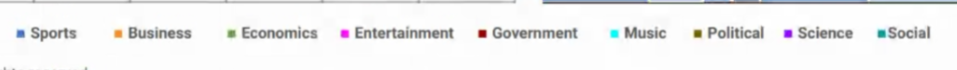

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pandas as pd

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(embeds, test_size=0.2, random_state=42)

# Применение кластеризации на обучающей выборке
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto").fit(X_train)

# Предсказание кластеров на всех данных
labels = kmeans.predict(embeds)

# Добавление предсказанных меток кластеров в DataFrame
df['Cluster'] = labels

## Clusters Name

In [41]:
df

,Time,Source,Topic,Cluster
0,2024-03-03,Twitter,Rashford,5
1,2024-03-03,Twitter,#sundayvibes,7
2,2024-03-03,Twitter,Xavier Worthy,2
3,2024-03-03,Twitter,Foden,5
4,2024-03-03,Twitter,#UFCVegas87,1
...,...,...,...,...
76135,2017-03-18,Google,Robert Osborne,2
76136,2017-03-18,Google,Alejandra Campoverdi,5
76137,2017-03-18,Google,Drake More Life,3
76138,2017-03-18,Google,Drake More Life Download,3


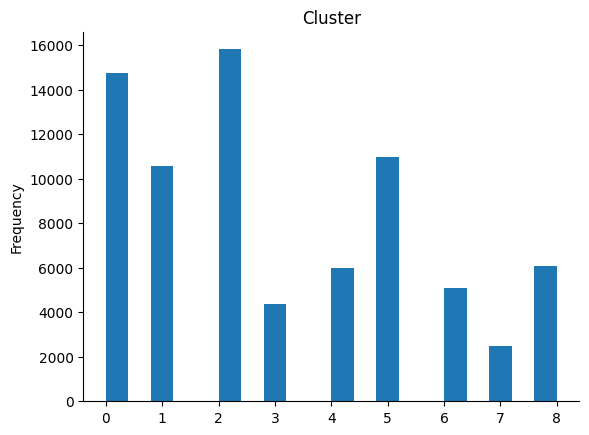

In [38]:
from matplotlib import pyplot as plt
df['Cluster'].plot(kind='hist', bins=20, title='Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [40]:
# Сортировка уникальных значений кластеров
unique_clusters = sorted(df['Cluster'].unique())

# Группировка данных по кластеру (в данном случае по дате)
grouped = df.groupby('Cluster')['Topic'].value_counts()

# Вывод 15 самых часто встречающихся представителей по каждому кластеру в отсортированном порядке
for cluster in unique_clusters:
    print(f"For cluster {cluster}:")
    if cluster in grouped.index:
        print(grouped[cluster].nlargest(15))
    else:
        print("No data")
    print()


For cluster 0:
Topic
Elon Musk        47
Dow Jones        44
Nets             40
Mega Millions    34
Apple            33
Bad Bunny        32
Bitcoin          32
Alex Jones       30
Pence            29
Juneteenth       28
Amber Alert      27
Antifa           27
Bitcoin price    27
Zoom             27
Trump            26
Name: Topic, dtype: int64

For cluster 1:
Topic
#Caturday           89
#FlashbackFriday    80
#LivePD             41
#LakeShow           22
#PitMad             21
#PortfolioDay       21
#VenmoMe            19
#earthquake         19
#ARMYSelcaDay       18
#FursuitFriday      18
Trump Twitter       17
#InsecureHBO        16
#QueenRadio         16
#GoBlue             15
#SnowfallFX         15
Name: Topic, dtype: int64

For cluster 2:
Topic
UFC              58
Antonio Brown    53
Tiger Woods      52
Supreme Court    51
Chris Paul       44
Jimmy Butler     44
Jimmy Carter     44
Rand Paul        42
Klay             41
Paul George      40
Steph            39
Lamar Jackson    3

Conclusion:
0. Business
1. Social events*
2. Basketball players
3. Music
4. Political
5. Global News
6. Football, Basketball, other Teams
7. Motivational Day journaling
8. American football Teams

In [49]:
import pickle

# Сохранение списка embeds в файл
with open('df_before_naming.pkl', 'wb') as f:
    pickle.dump(df, f)

In [50]:
# Загрузка списка embeds из файла
with open('df_before_naming.pkl', 'rb') as f:
    df_before_naming = pickle.load(f)

df_before_naming

,Time,Source,Topic,Cluster
0,2024-03-03,Twitter,Rashford,Global News
1,2024-03-03,Twitter,#sundayvibes,Motivational Day journaling
2,2024-03-03,Twitter,Xavier Worthy,Basketball players
3,2024-03-03,Twitter,Foden,Global News
4,2024-03-03,Twitter,#UFCVegas87,Social events
...,...,...,...,...
76135,2017-03-18,Google,Robert Osborne,Basketball players
76136,2017-03-18,Google,Alejandra Campoverdi,Global News
76137,2017-03-18,Google,Drake More Life,Music
76138,2017-03-18,Google,Drake More Life Download,Music


In [46]:
cluster_names = {
    0: "Business",
    1: "Social events",
    2: "Basketball players",
    3: "Music",
    4: "Political",
    5: "Global News",
    6: "Football, Basketball, other Teams",
    7: "Motivational Day journaling",
    8: "American football Teams"
}
df["Cluster"] = df["Cluster"].map(cluster_names)

In [51]:
# redo
df["Cluster"] = df["Cluster"].map({v: k for k, v in cluster_names.items()})

In [54]:
cluster_names = {
    0: "Business",
    1: "Social events",
    2: "Basketball players",
    3: "Music",
    4: "Political",
    5: "Global News",
    6: "Football, Basketball, other Teams",
    7: "Motivational Day journaling",
    8: "American football Teams"
}
df["Cluster name"] = df["Cluster"].map(cluster_names)

In [55]:
df

,Time,Source,Topic,Cluster,Cluster name
0,2024-03-03,Twitter,Rashford,5,Global News
1,2024-03-03,Twitter,#sundayvibes,7,Motivational Day journaling
2,2024-03-03,Twitter,Xavier Worthy,2,Basketball players
3,2024-03-03,Twitter,Foden,5,Global News
4,2024-03-03,Twitter,#UFCVegas87,1,Social events
...,...,...,...,...,...
76135,2017-03-18,Google,Robert Osborne,2,Basketball players
76136,2017-03-18,Google,Alejandra Campoverdi,5,Global News
76137,2017-03-18,Google,Drake More Life,3,Music
76138,2017-03-18,Google,Drake More Life Download,3,Music


## Forecast

<ipython-input-53-3a7cf6a8766f>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/rh3opm7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/ugh89qrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40844', 'data', 'file=/tmp/tmpi_4c3g7o/rh3opm7i.json', 'init=/tmp/tmpi_4c3g7o/ugh89qrc.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_model7o

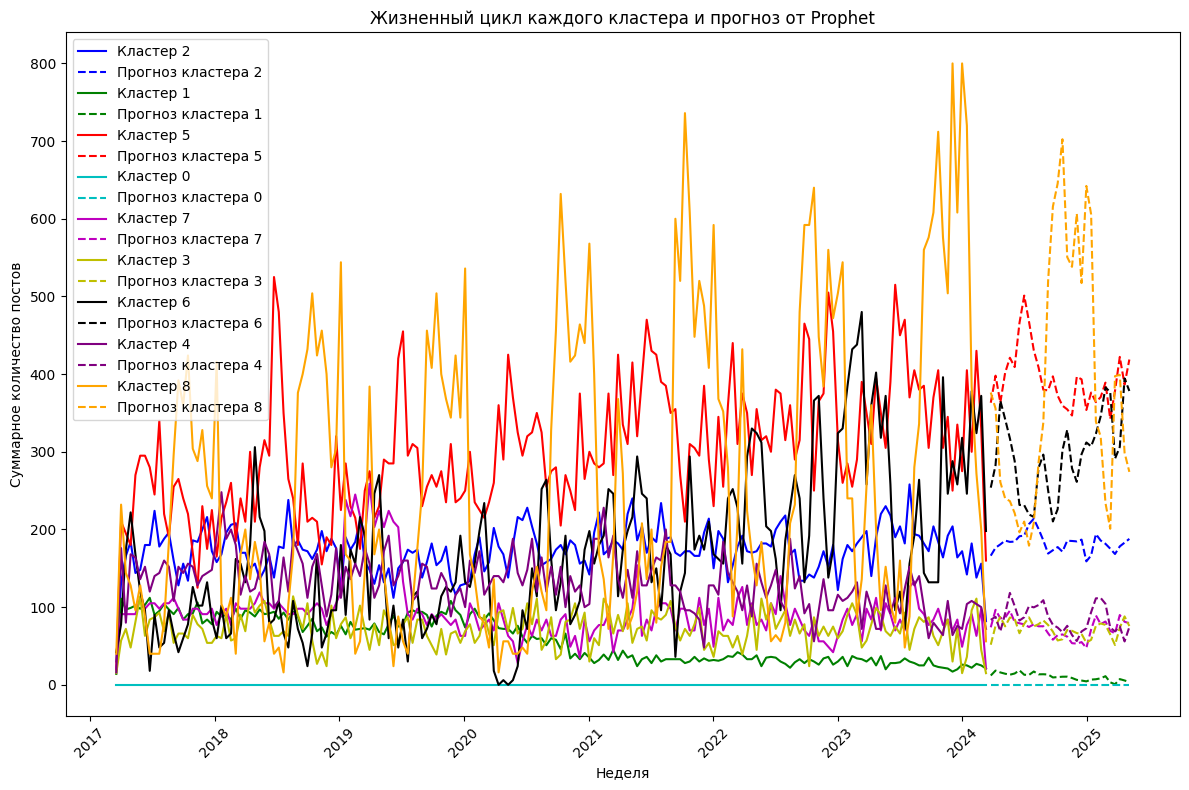

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

# Отсортировать данные по времени
df_sorted = df.sort_values(by='Time')

# Преобразовать столбец 'Time' в формат datetime и установить его в качестве индекса
df_sorted['Time'] = pd.to_datetime(df_sorted['Time'])
df_sorted.set_index('Time', inplace=True)

# Создание графика жизненного цикла каждого кластера по неделям
plt.figure(figsize=(12, 8))

# Список цветов для каждого кластера
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange']

# Перебор всех кластеров
for i, cluster in enumerate(df_sorted['Cluster'].unique()):
    # Фильтрация данных для текущего кластера
    cluster_data = df_sorted[df_sorted['Cluster'] == cluster]
    # Ресемплирование данных по двум неделям и вычисление суммарного количества постов для каждой недели
    cluster_data_weekly = cluster_data.resample('2W').sum()
    # Построение графика для текущего кластера
    plt.plot(cluster_data_weekly.index, cluster_data_weekly.values,
             label=f'Кластер {cluster}', color=colors[i])

    # Обучение модели Prophet на данных текущего кластера
    model = Prophet()
    cluster_data_prophet = cluster_data_weekly.reset_index().rename(columns={'Time': 'ds', 'Cluster': 'y'})
    model.fit(cluster_data_prophet)

    # Создание DataFrame для прогноза на 30 дней вперед
    future = model.make_future_dataframe(periods=30, freq='2W', include_history=False)

    # Получение прогноза для текущего кластера
    forecast = model.predict(future)

    # Построение прогноза для текущего кластера
    plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color=colors[i], label=f'Прогноз кластера {cluster}')

# Добавление заголовка и меток осей
plt.title('Жизненный цикл каждого кластера и прогноз от Prophet')
plt.xlabel('Неделя')
plt.ylabel('Суммарное количество постов')
plt.legend()  # Добавление легенды

# Поворот дат на оси x для лучшей читаемости
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/2hb2esc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/dn8kwe_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79692', 'data', 'file=/tmp/tmpi_4c3g7o/2hb2esc3.json', 'init=/tmp/tmpi_4c3g7o/dn8kwe_i.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelnf

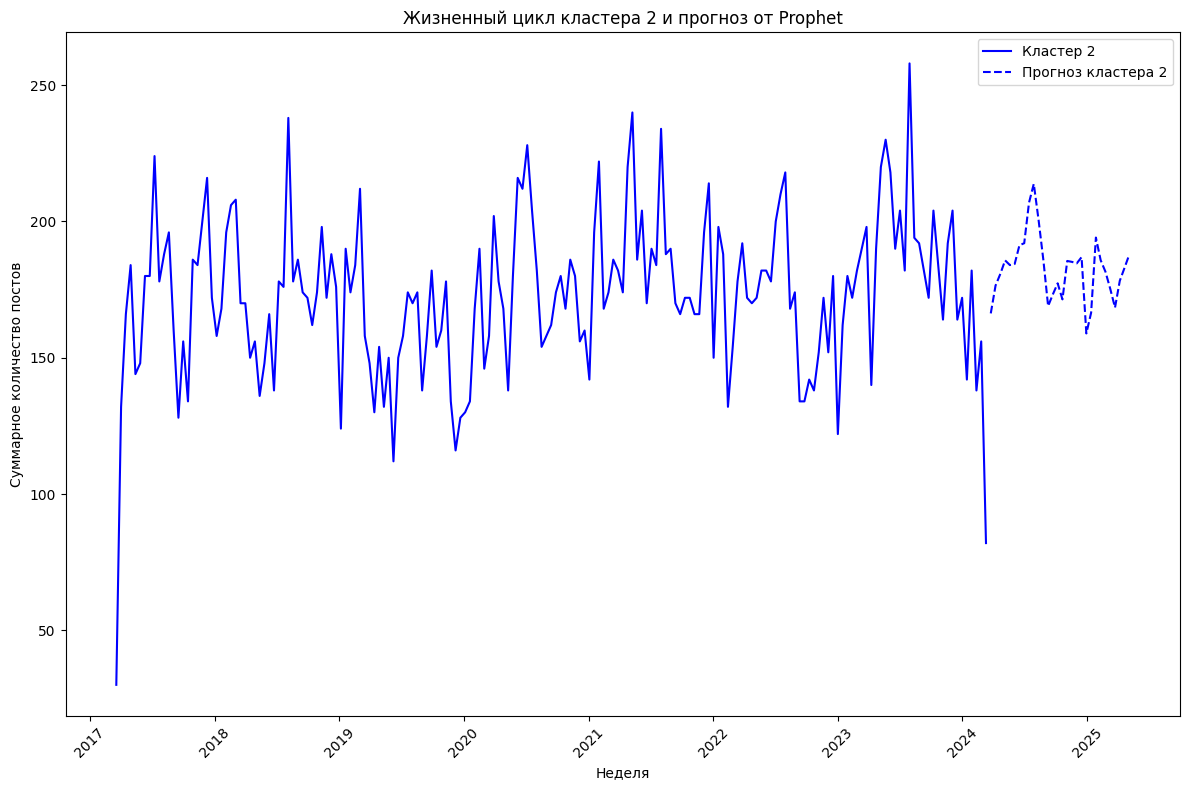

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/1ruc8576.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/qlo78w8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47238', 'data', 'file=/tmp/tmpi_4c3g7o/1ruc8576.json', 'init=/tmp/tmpi_4c3g7o/qlo78w8p.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modeljb

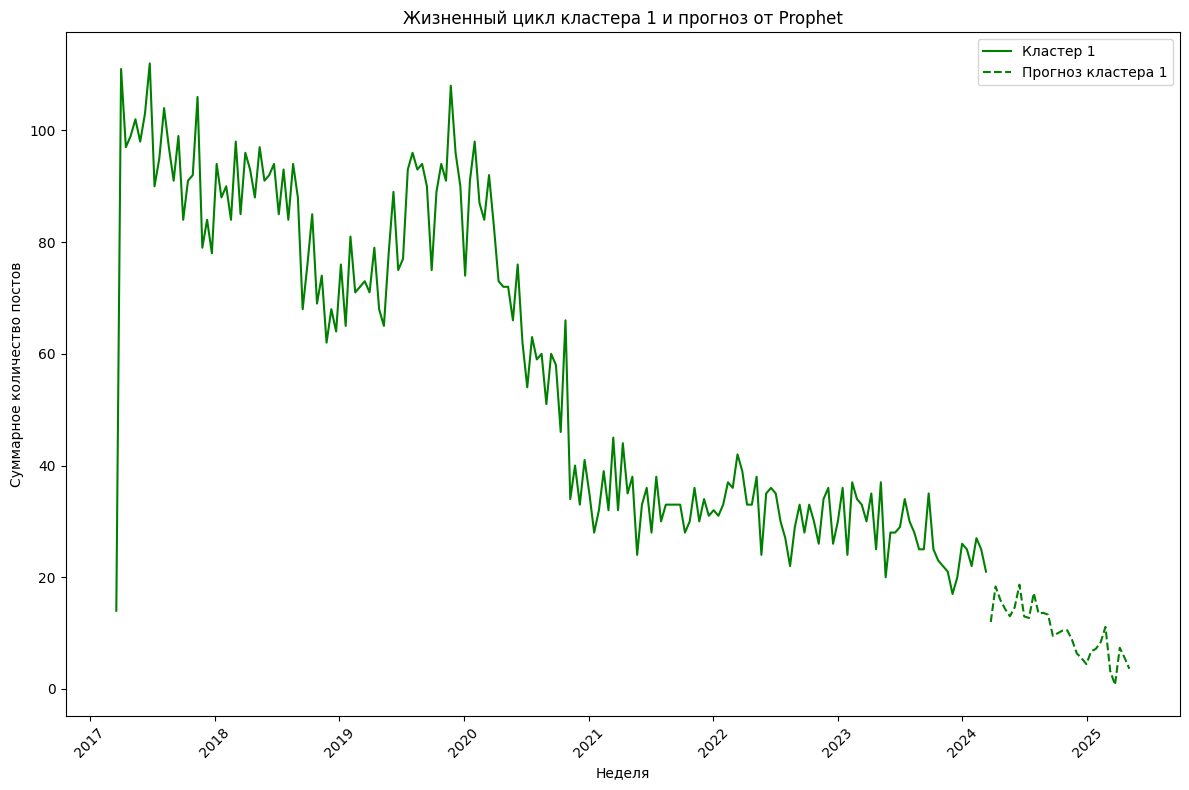

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/gx0s1zxi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/w74yqnhv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81703', 'data', 'file=/tmp/tmpi_4c3g7o/gx0s1zxi.json', 'init=/tmp/tmpi_4c3g7o/w74yqnhv.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelf9

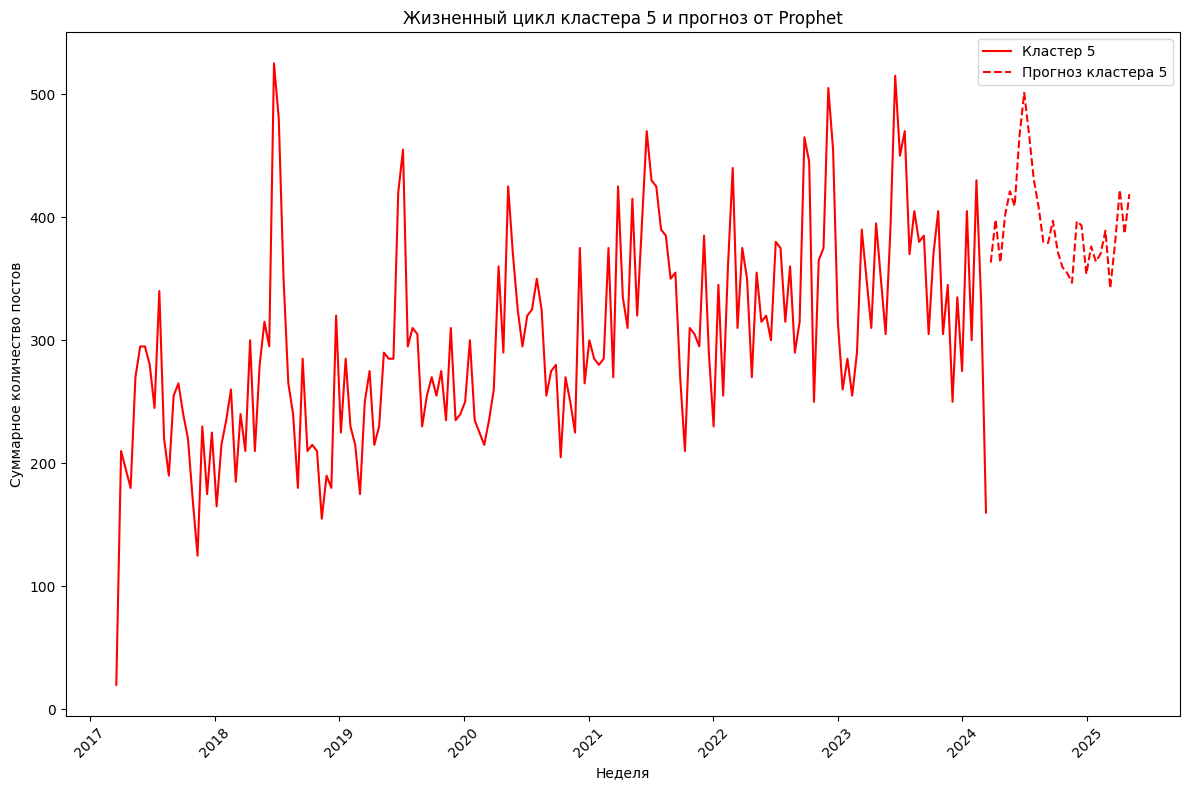

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


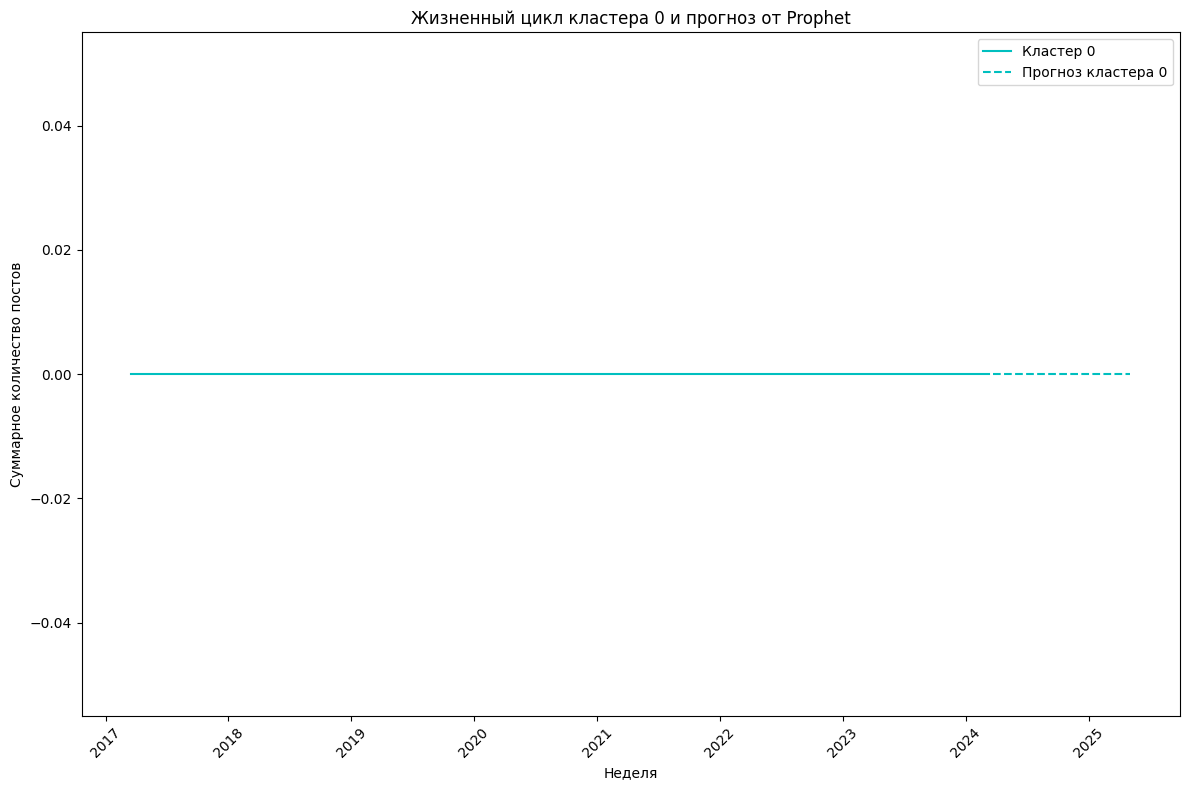

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/acuw8h3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/v_w1it8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29141', 'data', 'file=/tmp/tmpi_4c3g7o/acuw8h3n.json', 'init=/tmp/tmpi_4c3g7o/v_w1it8n.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelzw

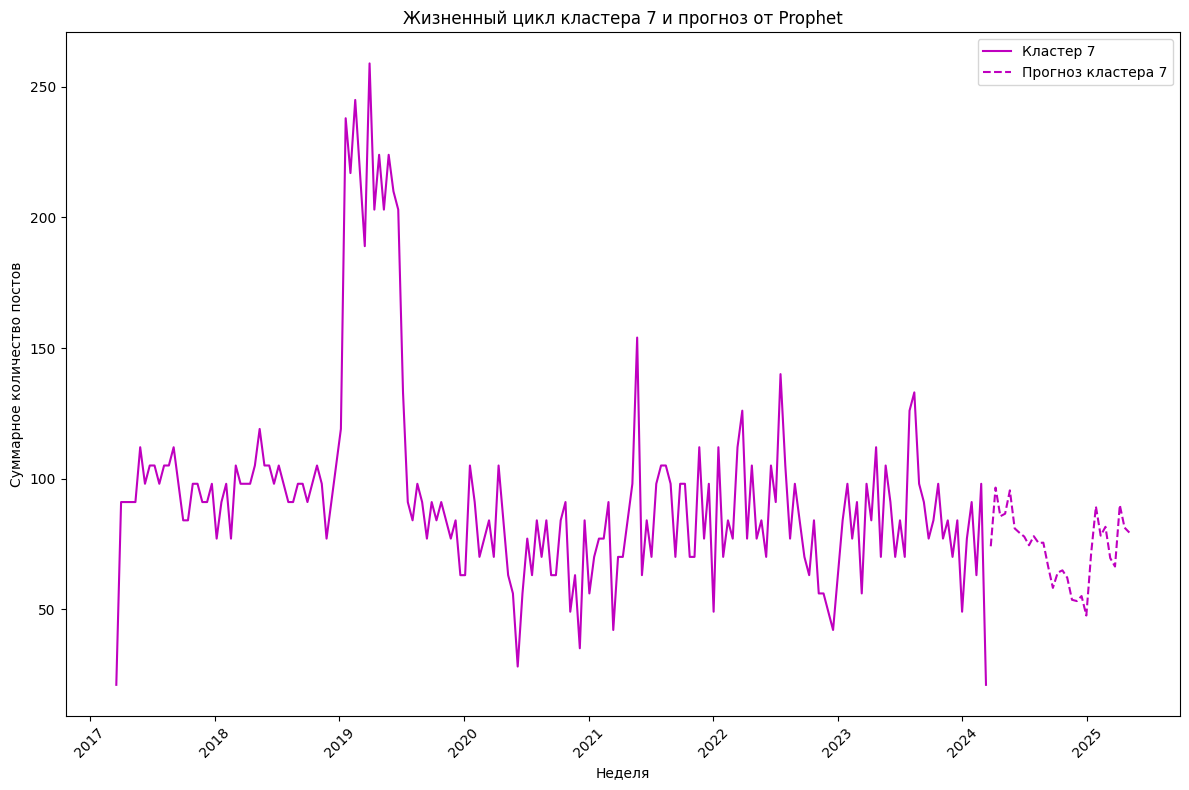

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/zcxmyhpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/hwarj5rz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93173', 'data', 'file=/tmp/tmpi_4c3g7o/zcxmyhpt.json', 'init=/tmp/tmpi_4c3g7o/hwarj5rz.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_model10

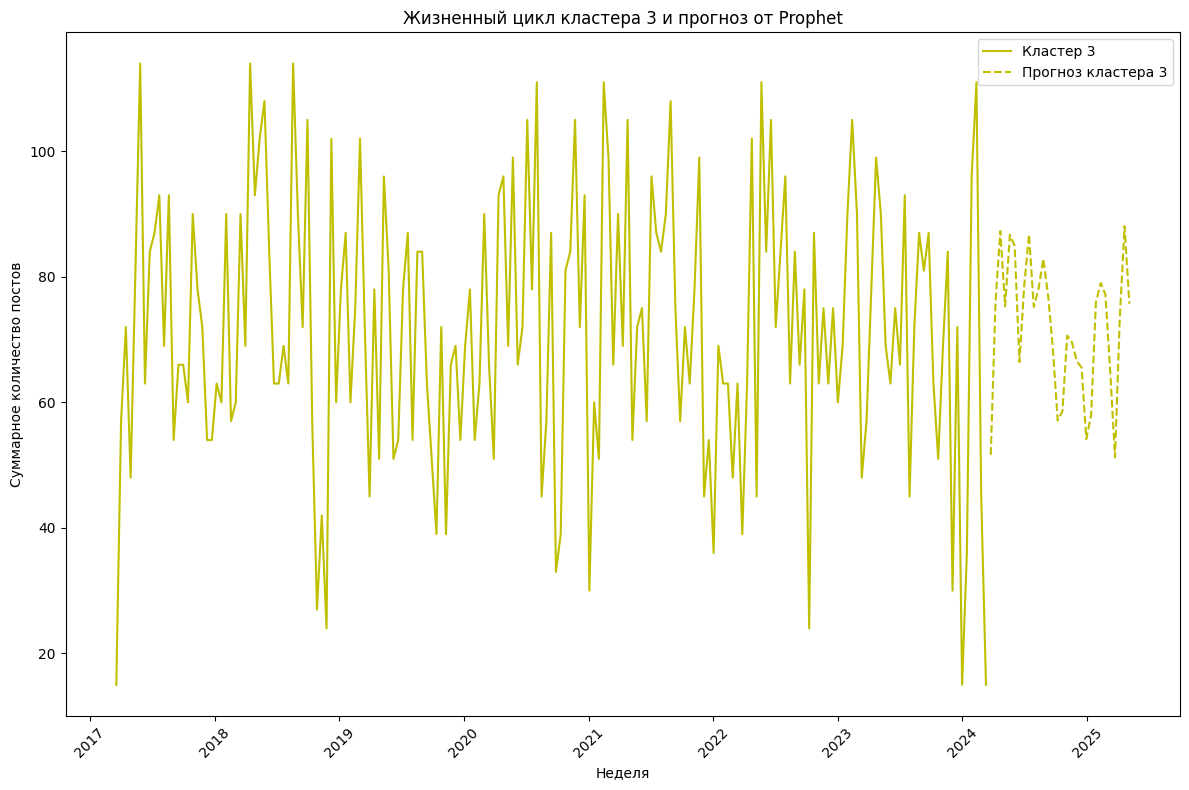

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/i2c0ohcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/v7zp4_4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94561', 'data', 'file=/tmp/tmpi_4c3g7o/i2c0ohcb.json', 'init=/tmp/tmpi_4c3g7o/v7zp4_4n.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelt2

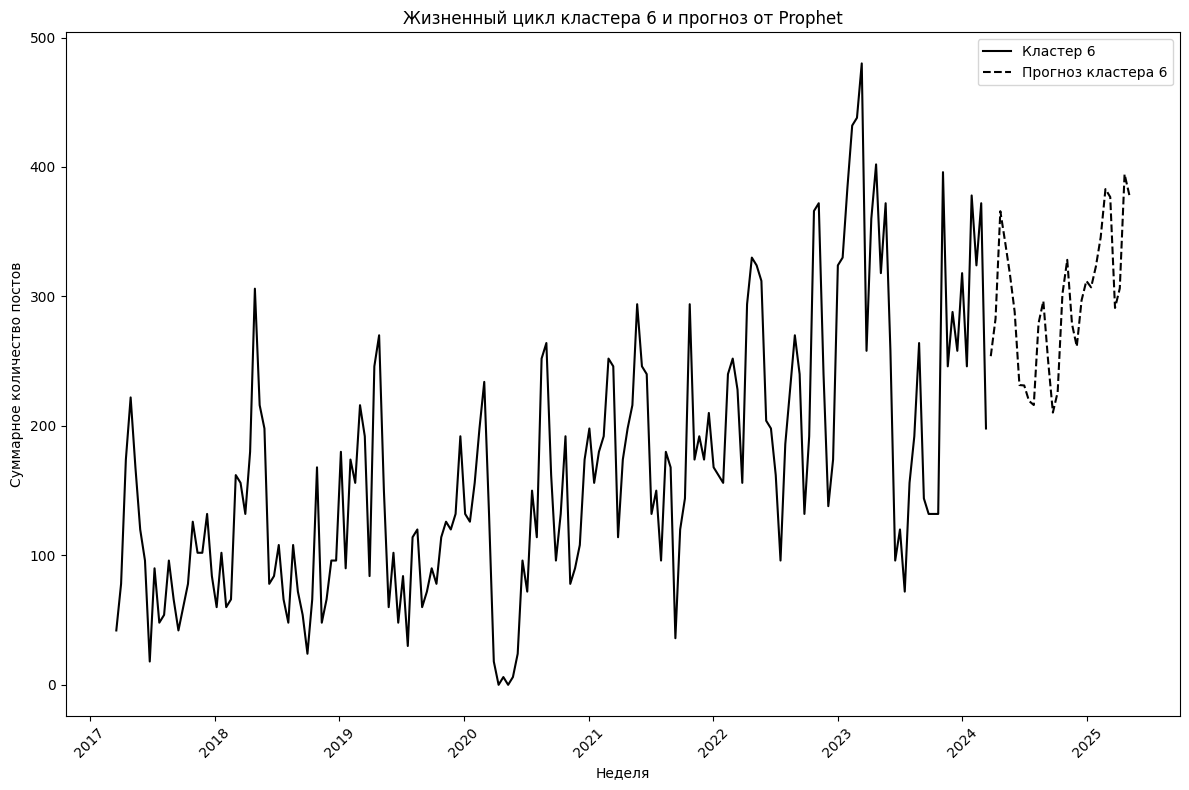

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/5gj3r0um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/x4xo731f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80903', 'data', 'file=/tmp/tmpi_4c3g7o/5gj3r0um.json', 'init=/tmp/tmpi_4c3g7o/x4xo731f.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modeloh

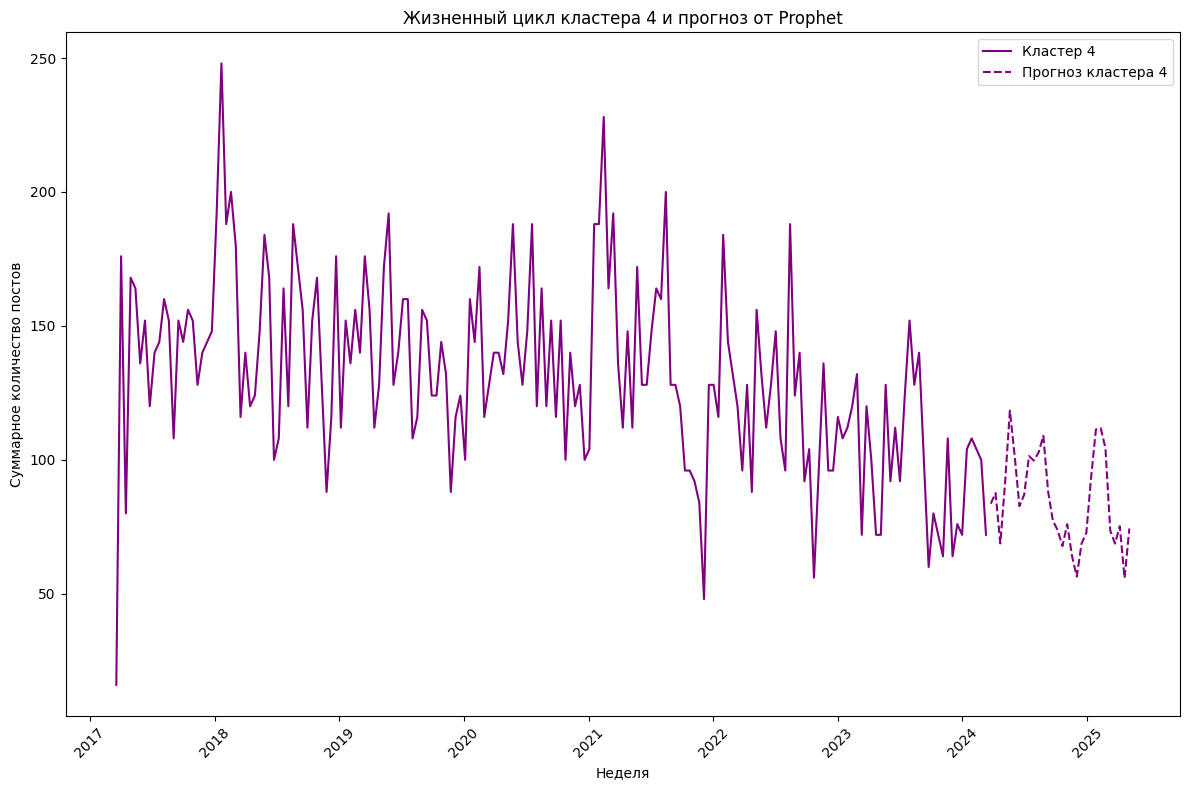

<ipython-input-18-280ac51e85f9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/xb8kdzcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/escmy36w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89168', 'data', 'file=/tmp/tmpi_4c3g7o/xb8kdzcm.json', 'init=/tmp/tmpi_4c3g7o/escmy36w.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelvn

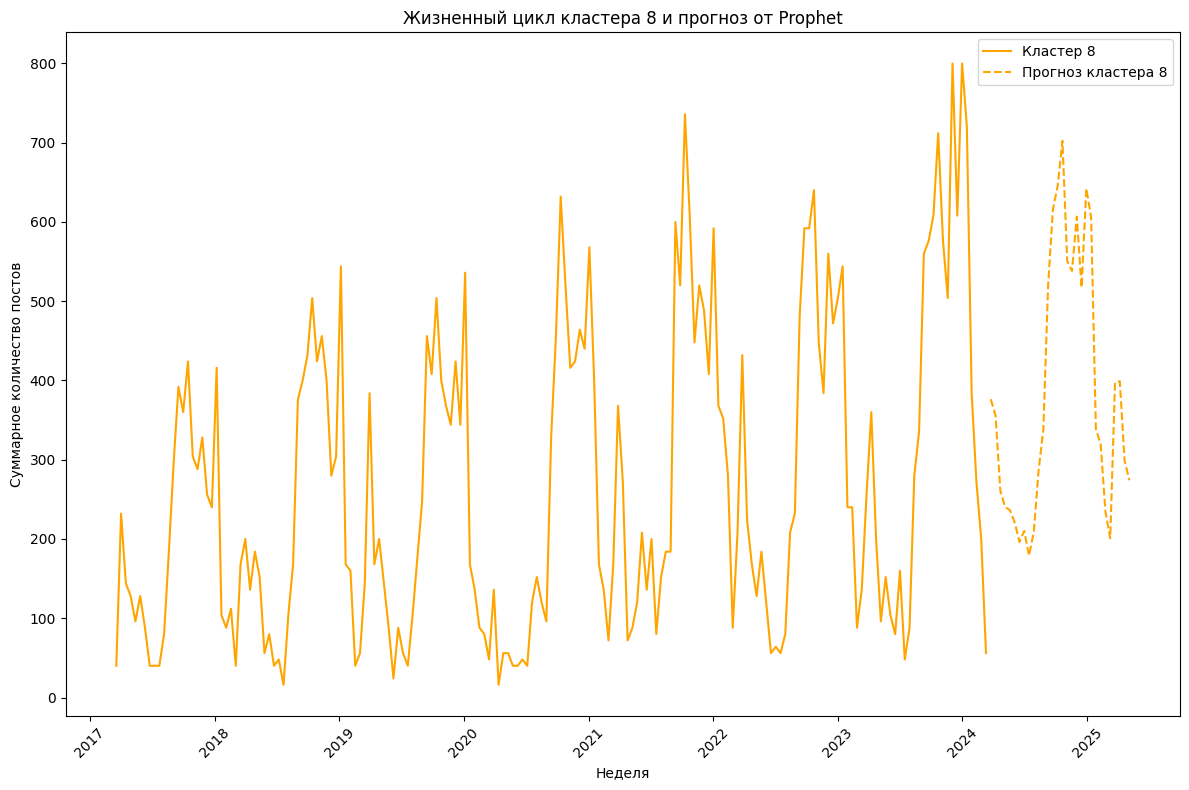

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

# Отсортировать данные по времени
df_sorted = df.sort_values(by='Time')

# Преобразовать столбец 'Time' в формат datetime и установить его в качестве индекса
df_sorted['Time'] = pd.to_datetime(df_sorted['Time'])
df_sorted.set_index('Time', inplace=True)

# Список цветов для каждого кластера
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange']

# Перебор всех кластеров
for i, cluster in enumerate(df_sorted['Cluster'].unique()):
    # Фильтрация данных для текущего кластера
    cluster_data = df_sorted[df_sorted['Cluster'] == cluster]
    # Ресемплирование данных по двум неделям и вычисление суммарного количества постов для каждой недели
    cluster_data_weekly = cluster_data.resample('2W').sum()

    # Создание графика для текущего кластера
    plt.figure(figsize=(12, 8))
    plt.plot(cluster_data_weekly.index, cluster_data_weekly.values, label=f'Кластер {cluster}', color=colors[i])

    # Обучение модели Prophet на данных текущего кластера
    model = Prophet()
    cluster_data_prophet = cluster_data_weekly.reset_index().rename(columns={'Time': 'ds', 'Cluster': 'y'})
    model.fit(cluster_data_prophet)

    # Создание DataFrame для прогноза на 30 дней вперед
    future = model.make_future_dataframe(periods=30, freq='2W', include_history=False)

    # Получение прогноза для текущего кластера
    forecast = model.predict(future)

    # Построение прогноза для текущего кластера
    plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color=colors[i], label=f'Прогноз кластера {cluster}')

    # Добавление заголовка и меток осей
    plt.title(f'Жизненный цикл кластера {cluster} и прогноз от Prophet')
    plt.xlabel('Неделя')
    plt.ylabel('Суммарное количество постов')
    plt.legend()  # Добавление легенды

    # Поворот дат на оси x для лучшей читаемости
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/n4k1368m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/k97knlj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34915', 'data', 'file=/tmp/tmpi_4c3g7o/n4k1368m.json', 'init=/tmp/tmpi_4c3g7o/k97knlj6.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modely0

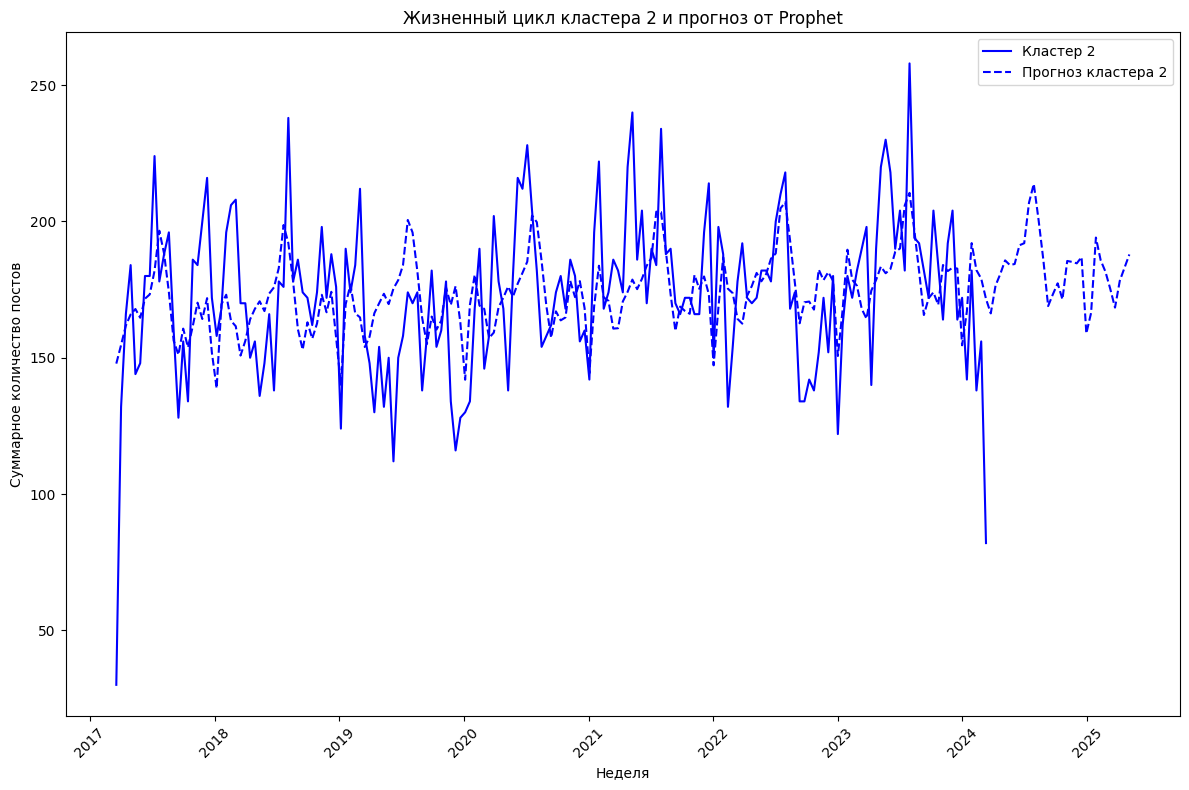

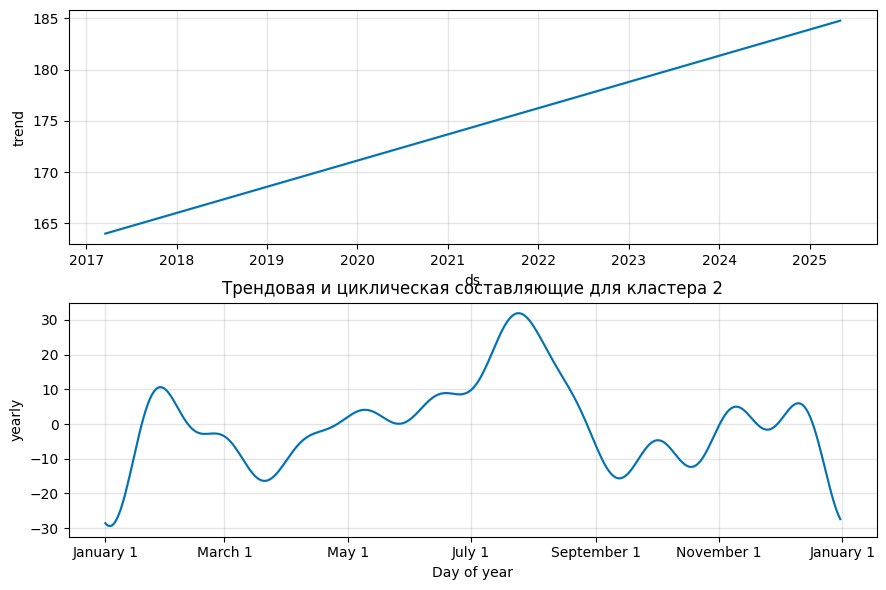

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/rv2mkgaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/04fzeedn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50184', 'data', 'file=/tmp/tmpi_4c3g7o/rv2mkgaz.json', 'init=/tmp/tmpi_4c3g7o/04fzeedn.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelrp

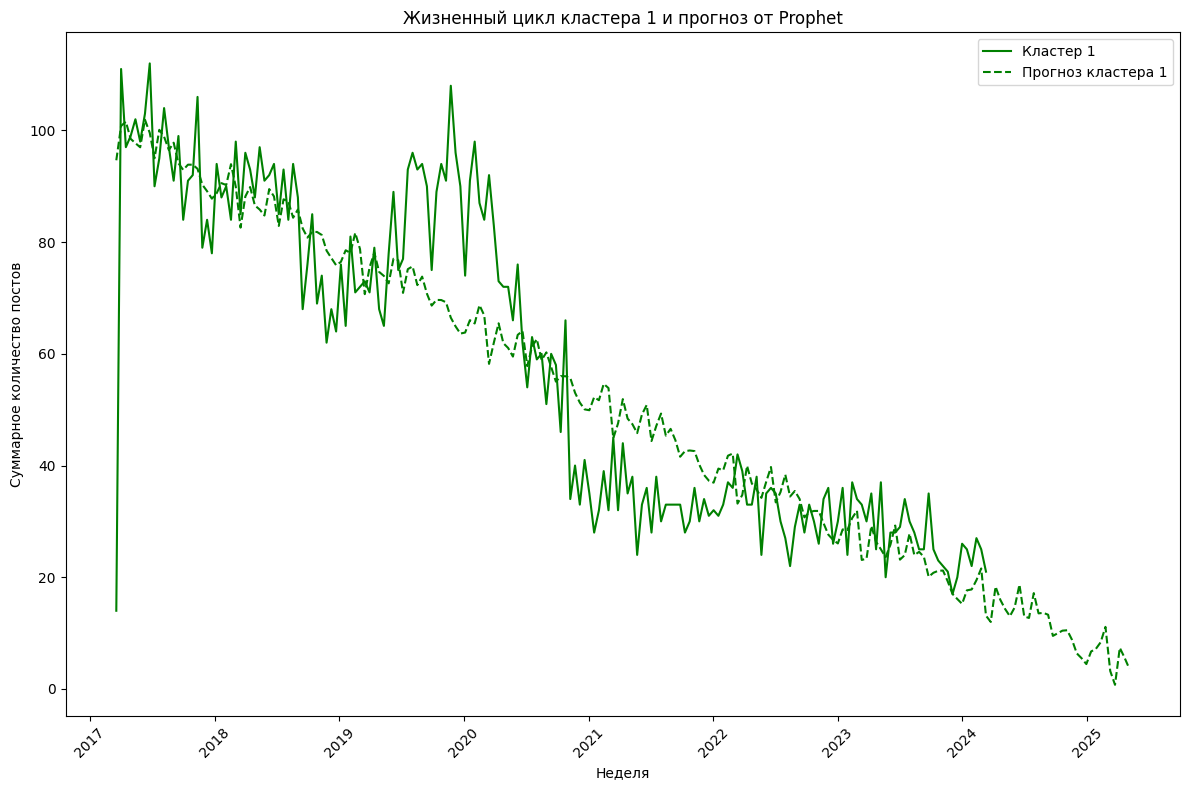

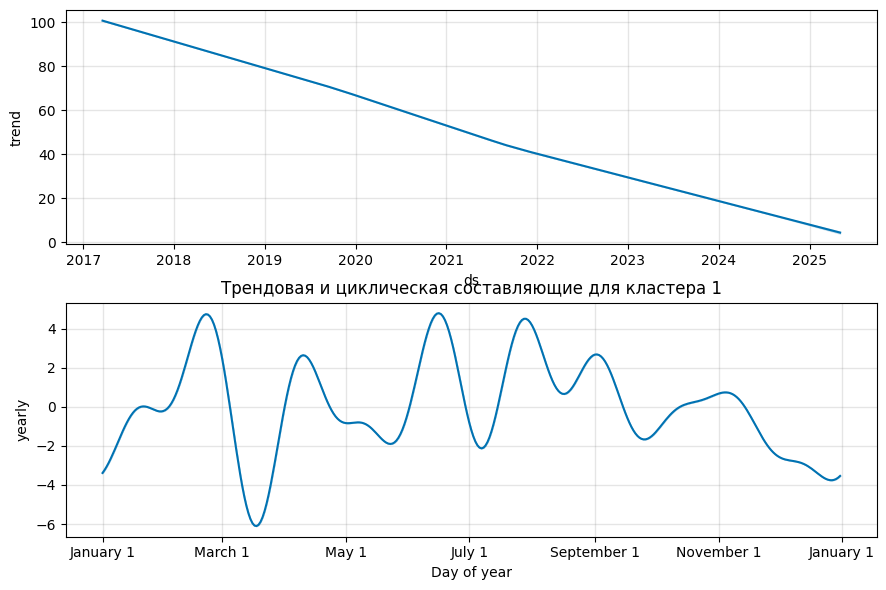

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/z2ml9ggi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/63io22qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47059', 'data', 'file=/tmp/tmpi_4c3g7o/z2ml9ggi.json', 'init=/tmp/tmpi_4c3g7o/63io22qf.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelbf

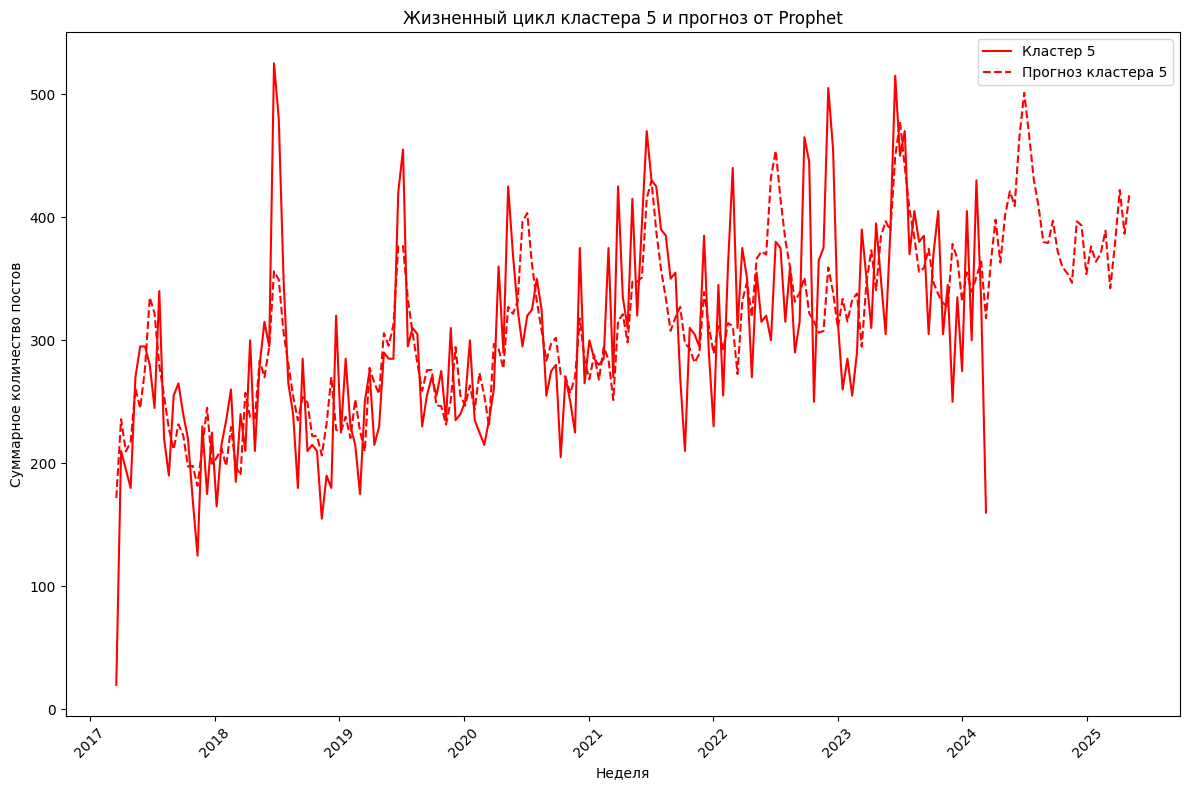

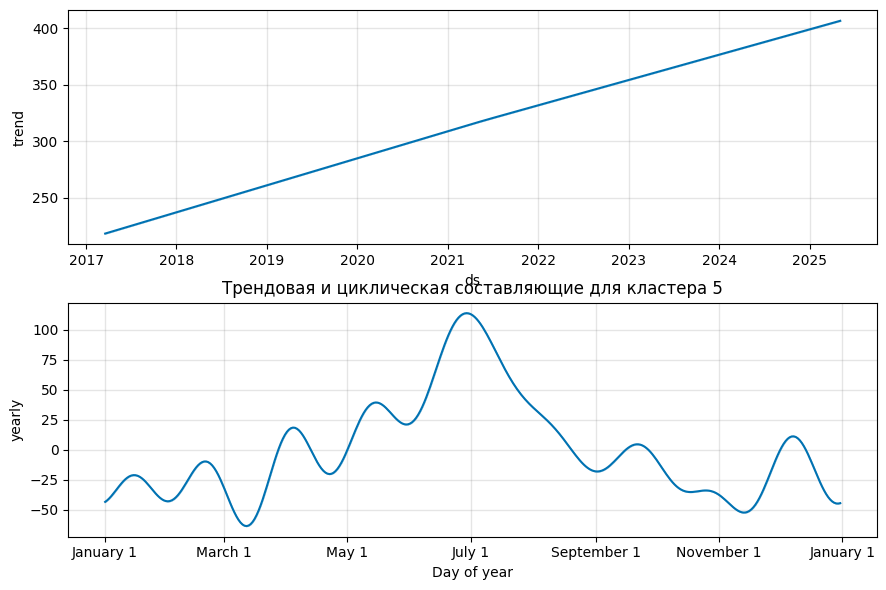

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


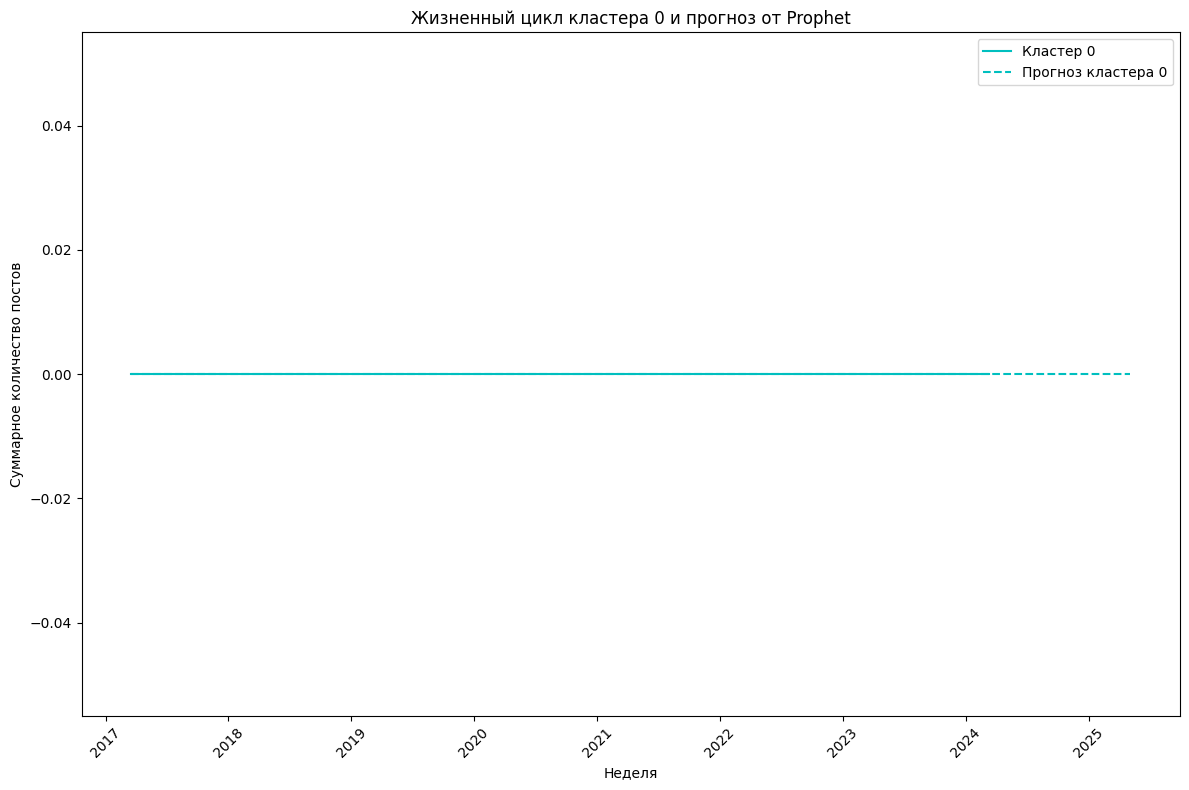

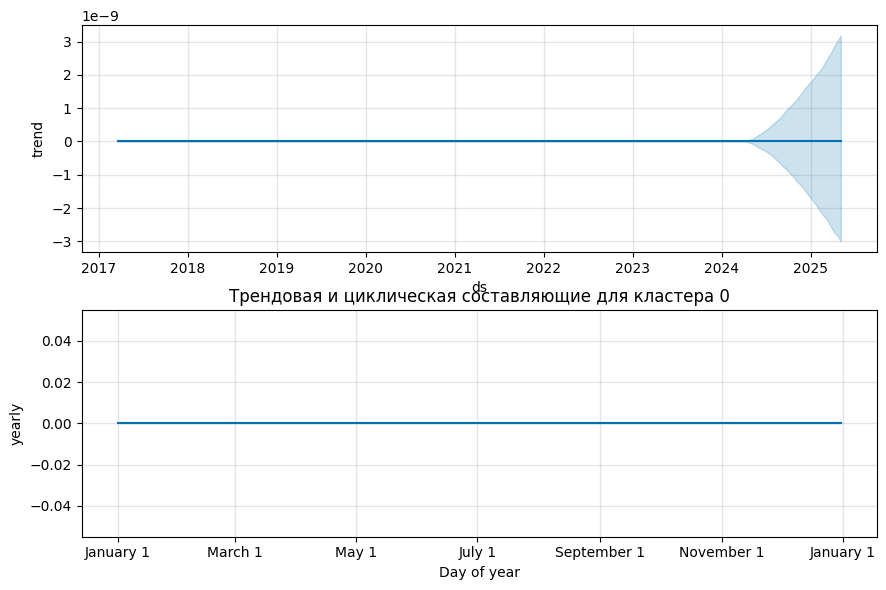

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/0kz3tan8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/ox3smmid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57188', 'data', 'file=/tmp/tmpi_4c3g7o/0kz3tan8.json', 'init=/tmp/tmpi_4c3g7o/ox3smmid.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modeljv

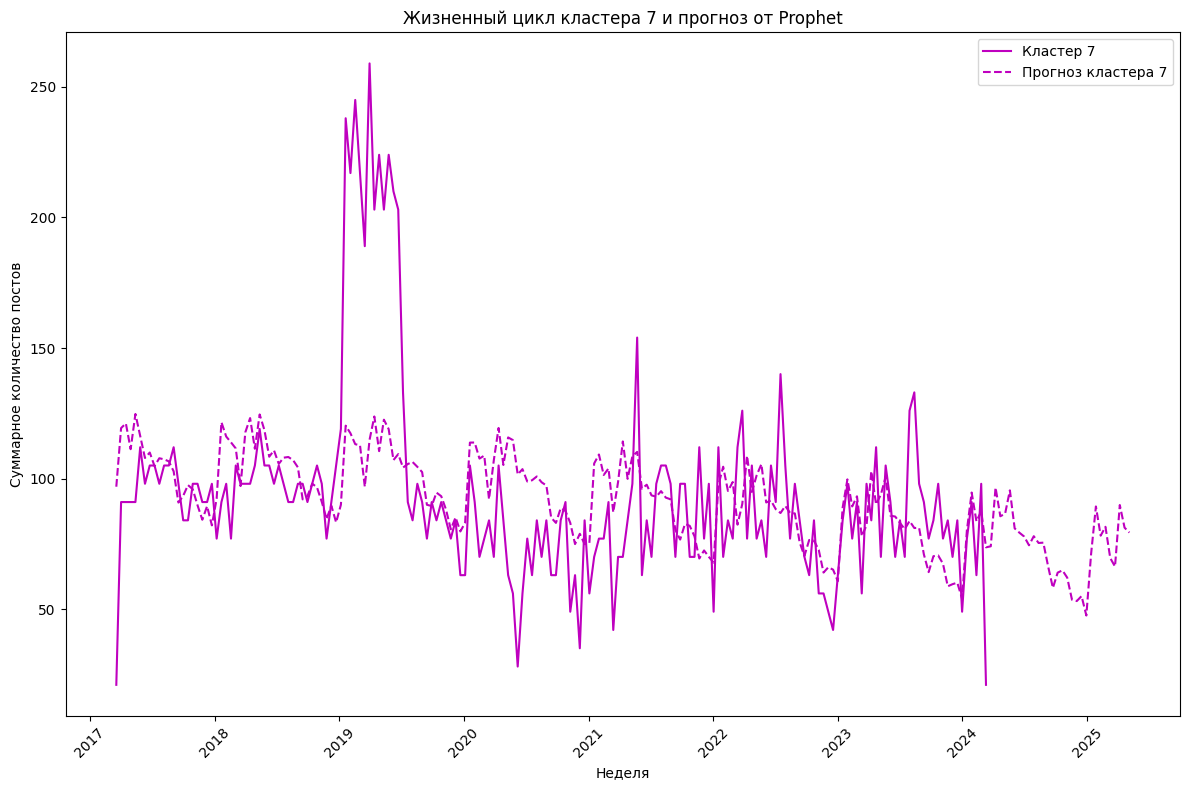

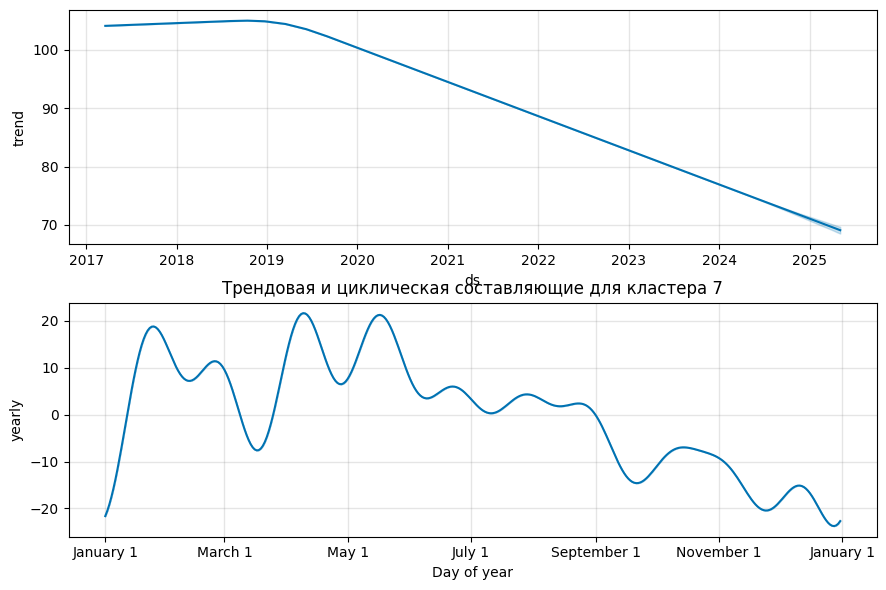

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/z_iahzz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/2m42jk7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22793', 'data', 'file=/tmp/tmpi_4c3g7o/z_iahzz1.json', 'init=/tmp/tmpi_4c3g7o/2m42jk7u.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelo_

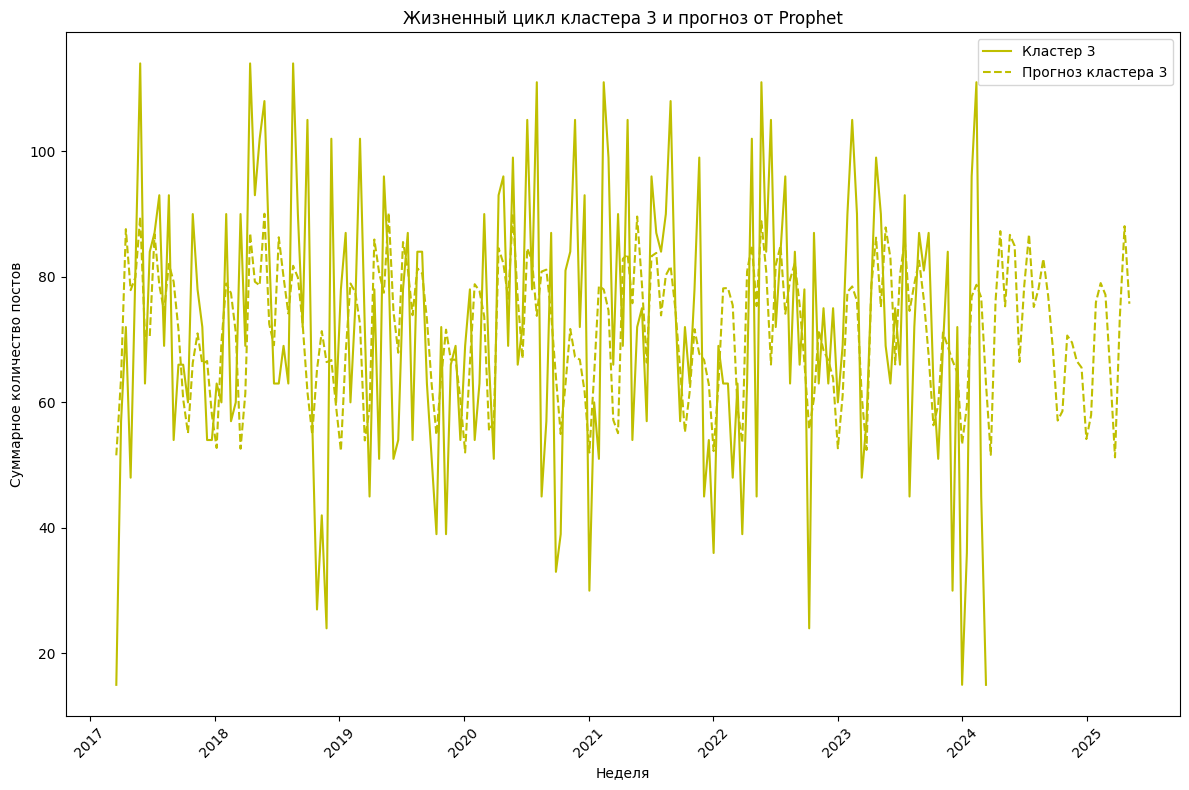

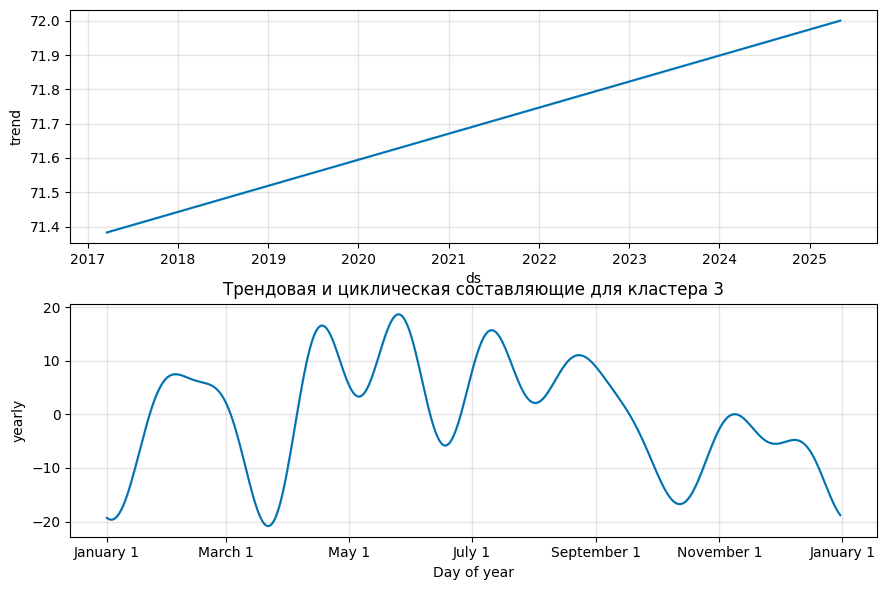

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/2buj5ibc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/yj4def3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38829', 'data', 'file=/tmp/tmpi_4c3g7o/2buj5ibc.json', 'init=/tmp/tmpi_4c3g7o/yj4def3c.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modela9

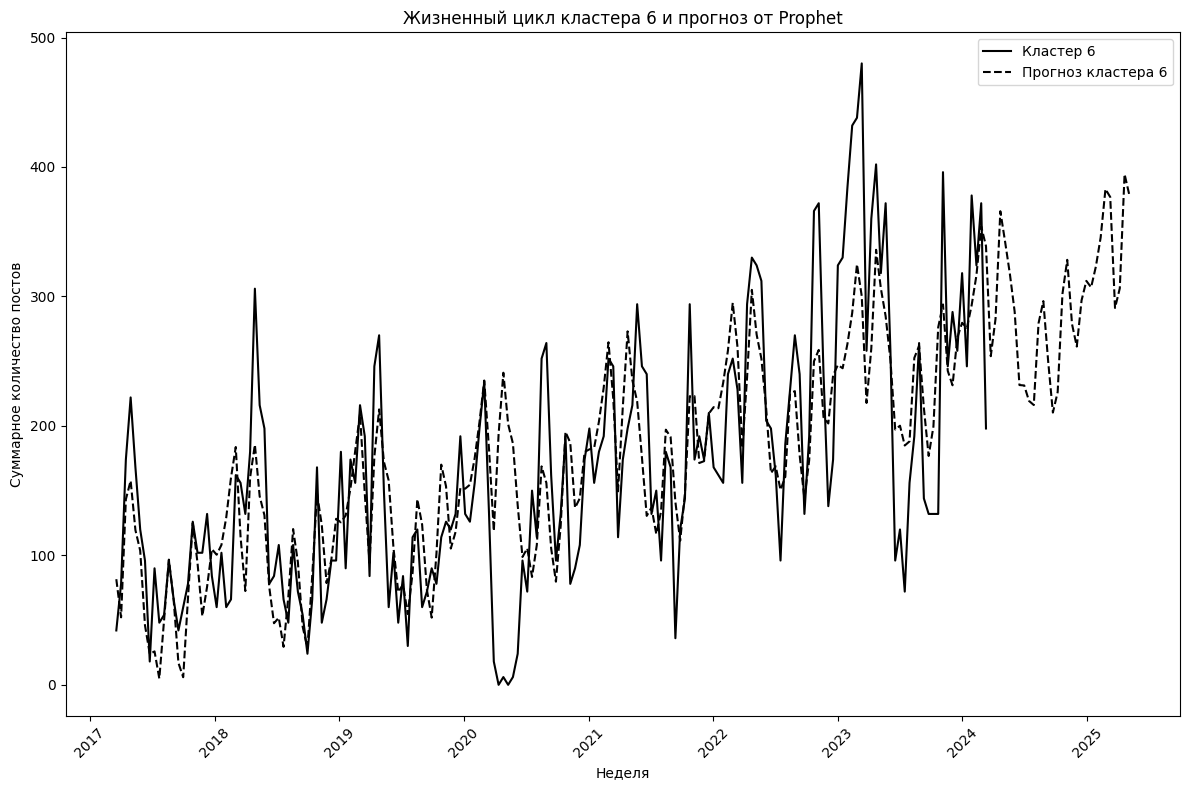

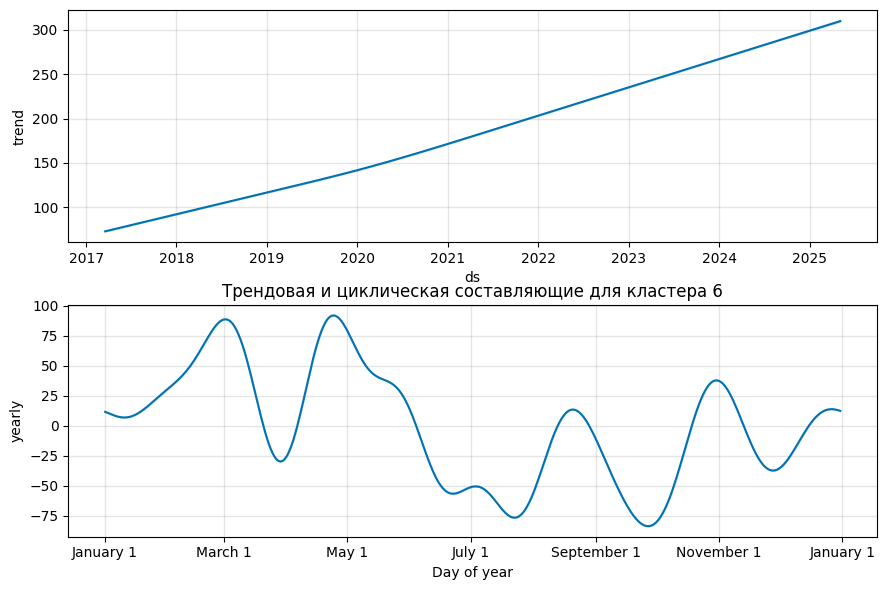

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/yuwj4ok0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/1xpa2_z_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65126', 'data', 'file=/tmp/tmpi_4c3g7o/yuwj4ok0.json', 'init=/tmp/tmpi_4c3g7o/1xpa2_z_.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_model7c

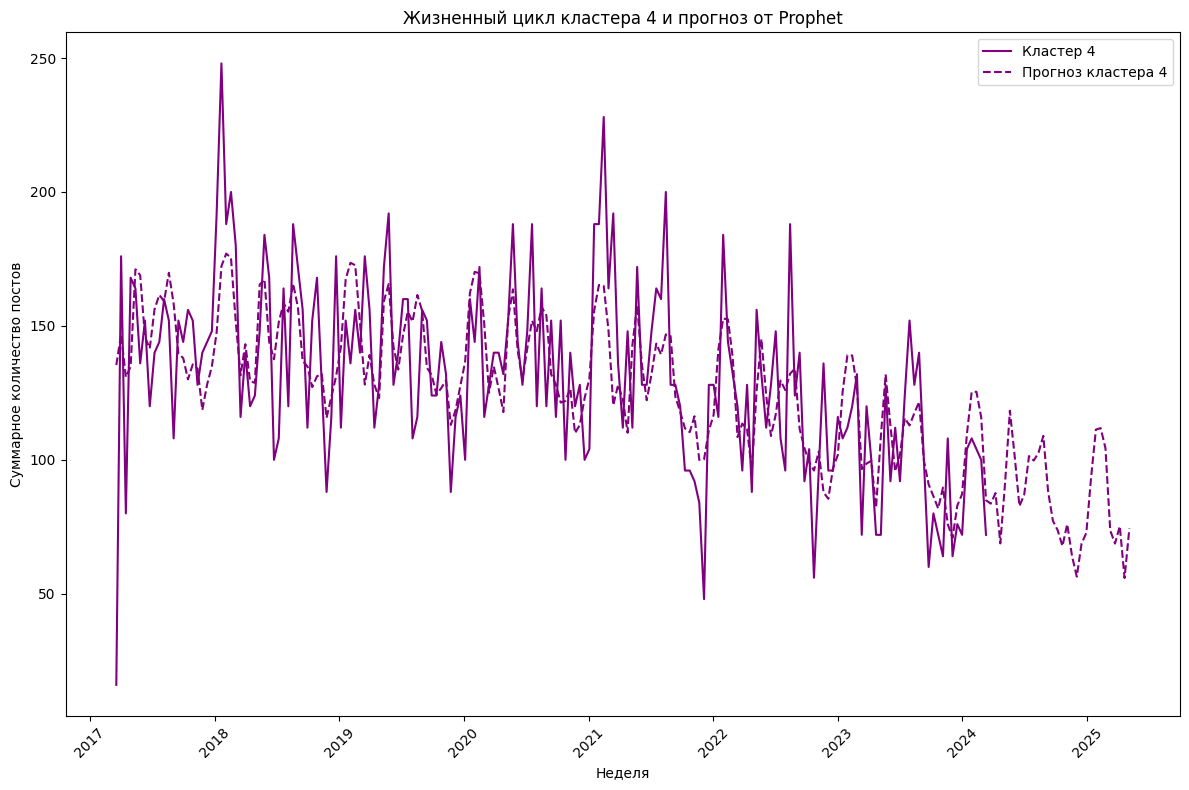

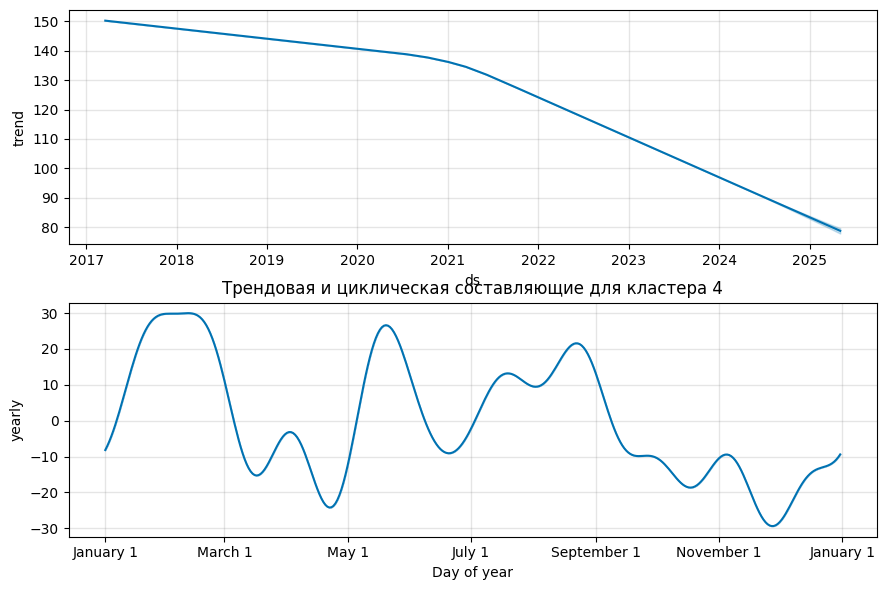

<ipython-input-26-e4e3183071c9>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_data_weekly = cluster_data.resample('2W').sum()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/pxcefhlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_4c3g7o/v4dg6c6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20829', 'data', 'file=/tmp/tmpi_4c3g7o/pxcefhlr.json', 'init=/tmp/tmpi_4c3g7o/v4dg6c6f.json', 'output', 'file=/tmp/tmpi_4c3g7o/prophet_modelui

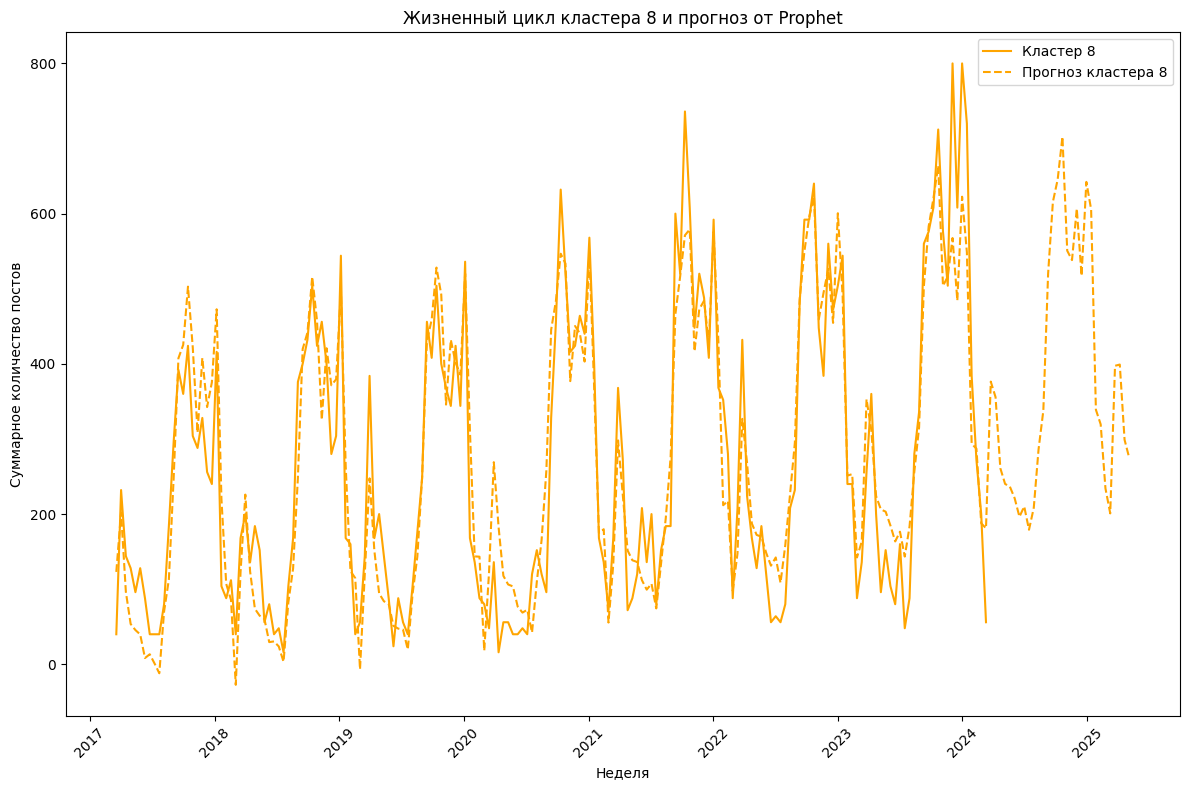

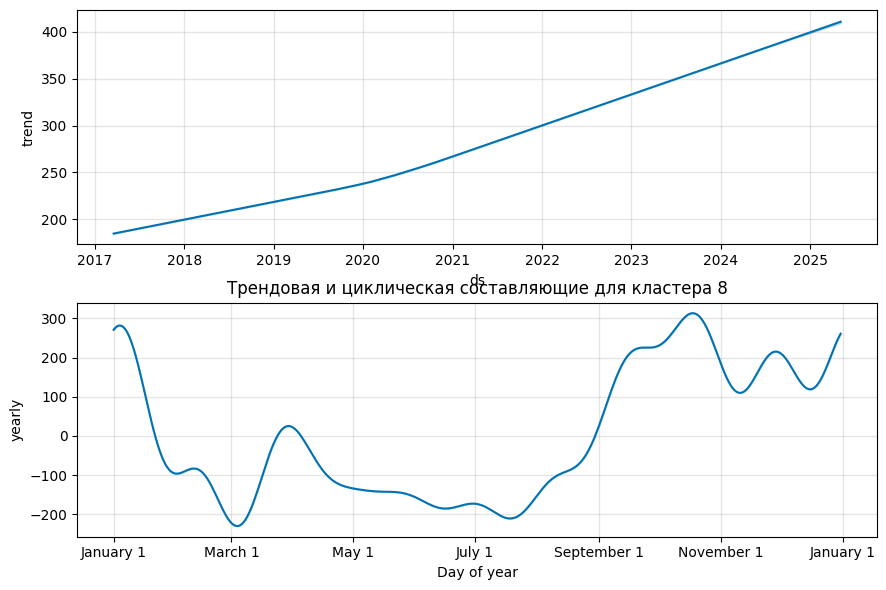

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

# Отсортировать данные по времени
df_sorted = df.sort_values(by='Time')

# Преобразовать столбец 'Time' в формат datetime и установить его в качестве индекса
df_sorted['Time'] = pd.to_datetime(df_sorted['Time'])
df_sorted.set_index('Time', inplace=True)

# Список цветов для каждого кластера
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange']

# Перебор всех кластеров
for i, cluster in enumerate(df_sorted['Cluster'].unique()):
    # Фильтрация данных для текущего кластера
    cluster_data = df_sorted[df_sorted['Cluster'] == cluster]
    # Ресемплирование данных по двум неделям и вычисление суммарного количества постов для каждой недели
    cluster_data_weekly = cluster_data.resample('2W').sum()

    # Создание графика для текущего кластера
    plt.figure(figsize=(12, 8))
    plt.plot(cluster_data_weekly.index, cluster_data_weekly.values, label=f'Кластер {cluster}', color=colors[i])

    # Обучение модели Prophet на данных текущего кластера
    model = Prophet()
    cluster_data_prophet = cluster_data_weekly.reset_index().rename(columns={'Time': 'ds', 'Cluster': 'y'})
    model.fit(cluster_data_prophet)

    # Создание DataFrame для прогноза на 30 дней вперед
    future = model.make_future_dataframe(periods=30, freq='2W', include_history=True)

    # Получение прогноза для текущего кластера
    forecast = model.predict(future)

    # Построение прогноза для текущего кластера
    plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color=colors[i], label=f'Прогноз кластера {cluster}')

    # Добавление заголовка и меток осей
    plt.title(f'Жизненный цикл кластера {cluster} и прогноз от Prophet')
    plt.xlabel('Неделя')
    plt.ylabel('Суммарное количество постов')
    plt.legend()  # Добавление легенды

    # Поворот дат на оси x для лучшей читаемости
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Вывод трендовой и циклической составляющих для текущего кластера
    fig = model.plot_components(forecast)
    plt.title(f'Трендовая и циклическая составляющие для кластера {cluster}')
    plt.show()


In [29]:
df_cluster_8 = df.loc[df['Cluster'] == 8]
df_cluster_8
# American football

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time'}, axis=1)
              .sort_values('Time', ascending=True))
  xs = counted['Time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cluster_8.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Source')):
  _plot_series(series, series_name, i)
  fig.legend(title='Source', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Cluster']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Cluster'}, axis=1)
              .sort_values('Cluster', ascending=True))
  xs = counted['Cluster']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cluster_8.sort_values('Cluster', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Source')):
  _plot_series(series, series_name, i)
  fig.legend(title='Source', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('count()')

,Time,Source,Topic,Cluster
62,2024-02-28,Twitter,Michigan,8
74,2024-02-28,Twitter,NFLPA,8
116,2024-02-25,Twitter,Cubs,8
118,2024-02-25,Twitter,South Carolina,8
124,2024-02-24,Twitter,Duke,8
...,...,...,...,...
76109,2017-03-20,Google,Kentucky Basketball,8
76114,2017-03-19,Google,Xavier Basketball,8
76115,2017-03-19,Google,Michigan State basketball,8
76132,2017-03-18,Google,Usc Basketball,8
